<a href="https://colab.research.google.com/github/swilsonmfc/notebooks/blob/master/NeuralNetworksTraining.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Training Neural Networks
![Lungs](https://img.medscapestatic.com/pi/meds/ckb/55/16955tn.jpg)

# Setup

In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import keract 

from PIL import Image

import tensorflow as tf
import tensorflow.keras as keras

from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Softmax
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Activation
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

from tensorflow.keras.applications import VGG16
import tensorflow.keras.applications.vgg16

In [128]:
tf.__version__

'2.2.0'

# Kaggle

In [129]:
!pip install kaggle
!mkdir -p ~/.kaggle

In [0]:
from google.colab import files
files.upload()

In [0]:
!mv kaggle.json ~/.kaggle
!chmod 600 ~/.kaggle/kaggle.json

# Data

In [0]:
!kaggle datasets download -d paultimothymooney/chest-xray-pneumonia

In [0]:
# Unzip quietly
!unzip -q /content/chest-xray-pneumonia.zip 

In [0]:
!ls /content/chest_xray/

## Validation Set
* Comes with 16 images in the validation set
* Take a few of the training images & increase it's size
* Should reduce some validation performance variance (easier to help with bias / variance)

In [0]:
# Expand the validation set
!cd /content/chest_xray/train/NORMAL; ls . | head -42 | xargs mv -t /content/chest_xray/val/NORMAL/
!cd /content/chest_xray/train/PNEUMONIA; ls . | head -42 | xargs mv -t /content/chest_xray/val/PNEUMONIA/

In [377]:
!ls /content/chest_xray/val/NORMAL | wc -l

50


In [378]:
!ls /content/chest_xray/val/PNEUMONIA | wc -l

50


## Class Balance
* We're imbalanced about 3 to 1 Pneumonia

In [234]:
ls /content/chest_xray/train/NORMAL | wc -l

1299


In [235]:
ls /content/chest_xray/train/PNEUMONIA | wc -l

3833


In [0]:
class_weight = {0: 3.,
                1: 1.}

# EDA

In [371]:
ls /content/chest_xray/train/NORMAL | head -n3

IM-0199-0001.jpeg
IM-0201-0001.jpeg
IM-0203-0001.jpeg


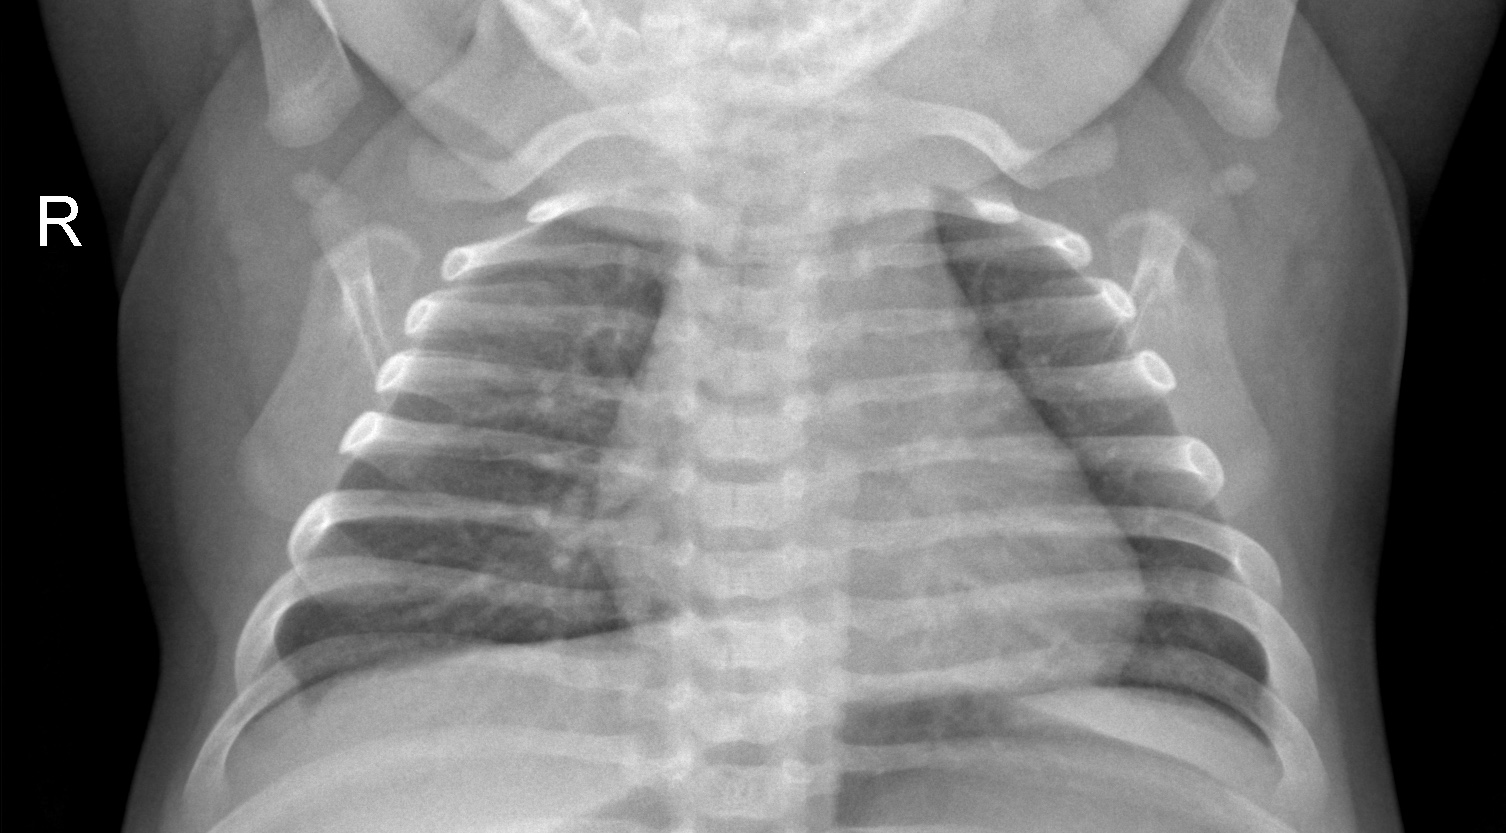

(1506, 833)


In [372]:
with Image.open('/content/chest_xray/train/NORMAL/IM-0199-0001.jpeg') as img:
  display(img)
  print(img.size)

## Viral

In [373]:
ls /content/chest_xray/train/PNEUMONIA | head -n3

person1024_virus_1716.jpeg
person1026_bacteria_2957.jpeg
person1026_virus_1718.jpeg


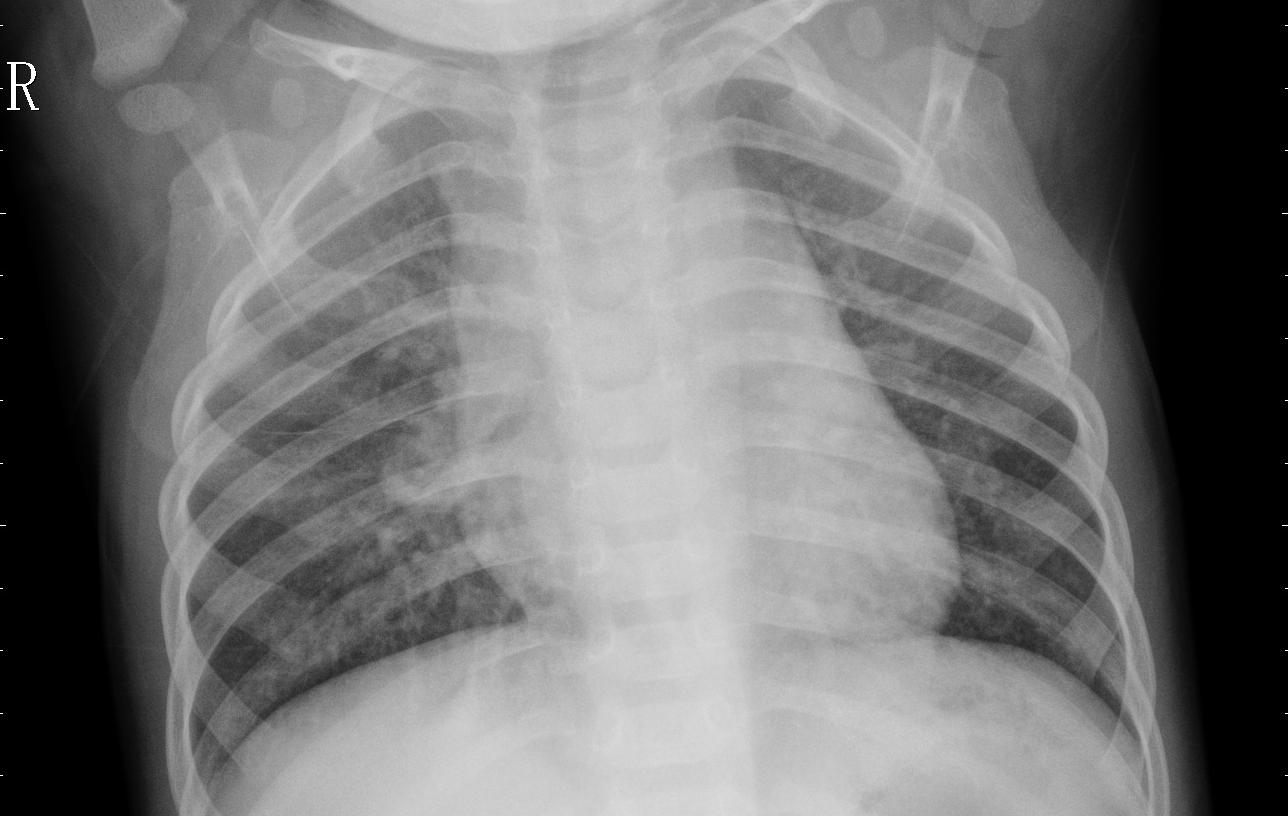

(1288, 816)


In [375]:
with Image.open('/content/chest_xray/train/PNEUMONIA/person1024_virus_1716.jpeg') as img:
  display(img)
  print(img.size)

## Bacterial

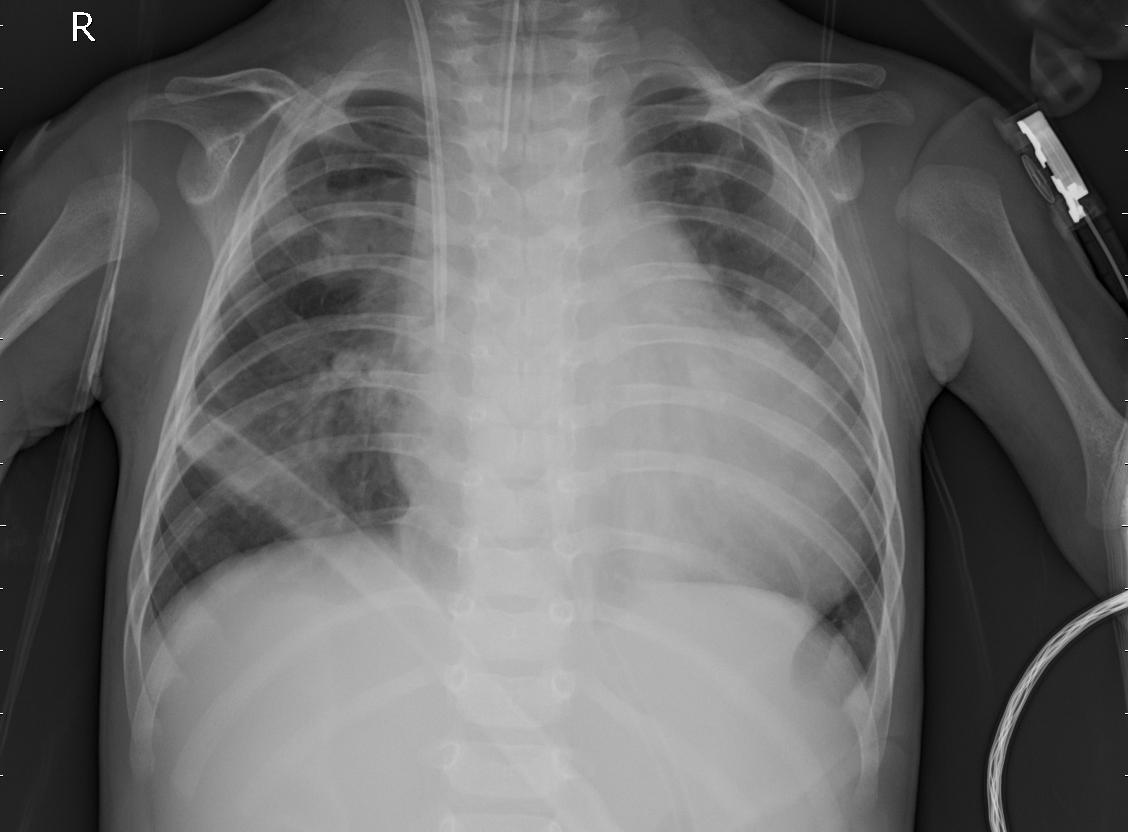

(1128, 832)


In [376]:
with Image.open('/content/chest_xray/train/PNEUMONIA/person1026_bacteria_2957.jpeg') as img:
  display(img)
  print(img.size)

# Parameters

In [0]:
train_dir = '/content/chest_xray/train'
val_dir =   '/content/chest_xray/val'
test_dir =  '/content/chest_xray/test'

In [0]:
image_x = 200
image_y = 200
input_shape = (image_x, image_y, 3)
class_names = ['NORMAL', 'PNEUMONIA']

In [0]:
batch_size = 64
epochs = 20

# Helpers

In [0]:
def plot_performance(history, color_train='blue', color_val='red'):
    fig, ax = plt.subplots(figsize=(12,10))
    
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    epochs = range(1, len(acc) + 1)
    ax = plt.subplot(2, 1, 1)
    plt.plot(epochs, acc, 'bo', color=color_train, label='Train')
    plt.plot(epochs, val_acc, 'b', color=color_val, label='Validation')
    plt.title('Training & Validation Accuracy')
    plt.ylabel('Accuracy')
    ax.legend()
    
    ax = plt.subplot(2, 1, 2)
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(1, len(loss) + 1)    
    plt.plot(epochs, loss, 'bo', color=color_train, label='Train')
    plt.plot(epochs, val_loss, 'b', color=color_val, label='Validation')
    plt.title('Training & Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

In [0]:
def compare_history(histories, metric='val_accuracy', ylabel='Accuracy', title='Validation Accuracy'):
    colors = (c for c in ['blue', 'orange', 'green', 'black', 'red', 'purple'])
    fig, ax = plt.subplots(figsize=(12,10))
    
    ax = plt.subplot(2, 1, 1)
    for key, history in histories.items():
        val_acc = history.history[metric]
        epochs = range(1, len(val_acc) + 1)
        plt.plot(epochs, val_acc, 'b', label=key, color=next(colors))   
        plt.title(title)
        plt.ylabel(ylabel)
    ax.legend()
    
    plt.show();

In [0]:
def print_classification_report(test, pred, target_names=class_names):
  report = classification_report(test, pred, target_names=target_names)
  print(report)  

def plot_confusion(test, pred):
    cm = confusion_matrix(test, pred)
    df = pd.DataFrame(cm, class_names, class_names)
    plt.figure(figsize=(10, 10))
    sns.heatmap(df, annot=True, fmt='d', cmap='BuGn')
    plt.xlabel('Prediction')
    plt.ylabel('Actual')
    plt.show()

def plot_roc_curve(test, pred_proba):
  fpr, tpr, _ = roc_curve(test,  pred_proba)
  auc = roc_auc_score(test, pred_proba)
  plt.figure(figsize=(10, 10))
  plt.plot(fpr, tpr, label=f'AUC = {auc}')
  plt.title('ROC Curve')
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.legend(loc=4)
  plt.show()

# Compare

In [0]:
results_df = pd.DataFrame(columns=['Loss', 'Accuracy'])

# Baseline
* Configure generators
* Use a simple network architecture to establish a baseline of performance

## Data Generators

In [0]:
train_datagen = ImageDataGenerator(
    rescale = 1. / 255
)

val_datagen = ImageDataGenerator(
    rescale = 1. / 255
)

test_datagen = ImageDataGenerator(
    rescale = 1. / 255
)

In [258]:
train_generator = train_datagen.flow_from_directory(train_dir, 
                                                    target_size=(image_x, image_y),
                                                    batch_size=batch_size,
                                                    class_mode='binary')

val_generator = val_datagen.flow_from_directory(val_dir, 
                                                    target_size=(image_x, image_y),
                                                    batch_size=batch_size,
                                                    class_mode='binary',
                                                    shuffle=False)

test_generator = test_datagen.flow_from_directory(test_dir, 
                                                    target_size=(image_x, image_y),
                                                    batch_size=batch_size,
                                                    class_mode='binary',
                                                    shuffle=False)

Found 5132 images belonging to 2 classes.
Found 100 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


## Model

In [0]:
model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=input_shape))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(32, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

In [260]:
model.summary()

Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_24 (Conv2D)           (None, 198, 198, 32)      896       
_________________________________________________________________
max_pooling2d_24 (MaxPooling (None, 99, 99, 32)        0         
_________________________________________________________________
conv2d_25 (Conv2D)           (None, 97, 97, 32)        9248      
_________________________________________________________________
max_pooling2d_25 (MaxPooling (None, 48, 48, 32)        0         
_________________________________________________________________
conv2d_26 (Conv2D)           (None, 46, 46, 64)        18496     
_________________________________________________________________
max_pooling2d_26 (MaxPooling (None, 23, 23, 64)        0         
_________________________________________________________________
flatten_12 (Flatten)         (None, 33856)           

In [0]:
model.compile(loss='binary_crossentropy',
              optimizer=Adam(lr=3e-4),
              metrics=['accuracy'])

## Train

In [268]:
history_baseline = model.fit(train_generator,
                             epochs=epochs,
                             validation_data=val_generator,
                             class_weight=class_weight)

Epoch 1/20
81/81 [==============================] - 51s 632ms/step - loss: 0.8061 - accuracy: 0.6278 - val_loss: 0.3181 - val_accuracy: 0.8900
Epoch 2/20
81/81 [==============================] - 50s 621ms/step - loss: 0.2684 - accuracy: 0.9306 - val_loss: 0.2210 - val_accuracy: 0.9000
Epoch 3/20
81/81 [==============================] - 50s 623ms/step - loss: 0.1700 - accuracy: 0.9571 - val_loss: 0.1858 - val_accuracy: 0.9200
Epoch 4/20
81/81 [==============================] - 51s 627ms/step - loss: 0.1676 - accuracy: 0.9585 - val_loss: 0.1712 - val_accuracy: 0.9200
Epoch 5/20
81/81 [==============================] - 51s 626ms/step - loss: 0.1431 - accuracy: 0.9632 - val_loss: 0.1617 - val_accuracy: 0.9400
Epoch 6/20
81/81 [==============================] - 50s 620ms/step - loss: 0.1234 - accuracy: 0.9702 - val_loss: 0.1569 - val_accuracy: 0.9400
Epoch 7/20
81/81 [==============================] - 50s 616ms/step - loss: 0.1262 - accuracy: 0.9684 - val_loss: 0.1546 - val_accuracy: 0.9400

## Test

In [0]:
pred_proba = model.predict(test_generator)
pred = model.predict_classes(test_generator)
y_test = test_generator.classes

In [270]:
results = model.evaluate(test_generator)
print(f'Test Loss {results[0]:.2f} Accuracy {results[1]*100.0:.2f}%')
results_df.loc['Baseline'] = [results[0], results[1]]

10/10 [==============================] - 4s 400ms/step - loss: 1.0300 - accuracy: 0.7853
Test Loss 1.03 Accuracy 78.53%


              precision    recall  f1-score   support

      NORMAL       0.96      0.44      0.61       234
   PNEUMONIA       0.75      0.99      0.85       390

    accuracy                           0.79       624
   macro avg       0.86      0.72      0.73       624
weighted avg       0.83      0.79      0.76       624



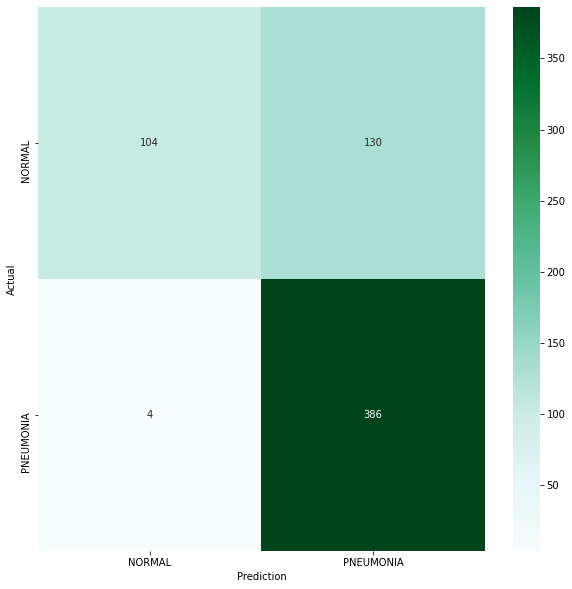

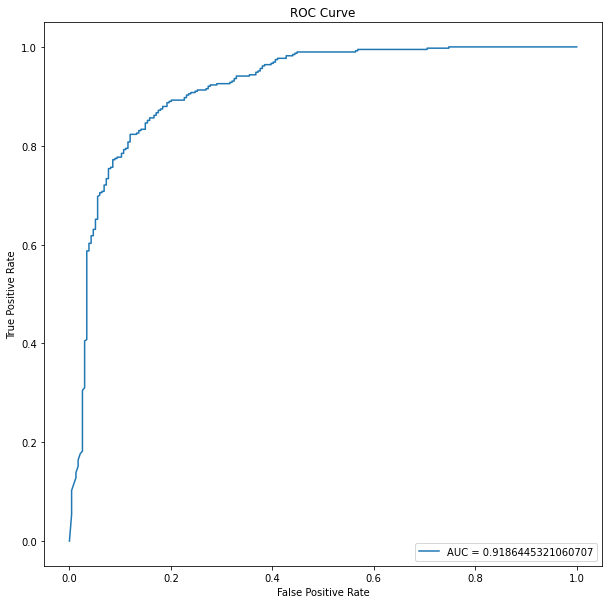

In [271]:
print_classification_report(y_test, pred)
plot_confusion(y_test, pred)
plot_roc_curve(y_test, pred_proba)

## Plots

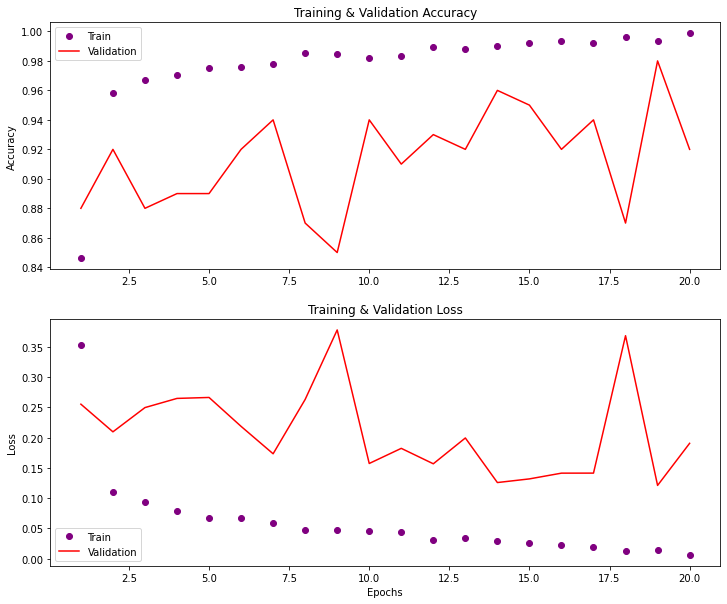

In [159]:
plot_performance(history_baseline, color_train='purple')

# Batch Normalization
![alt text](https://images.deepai.org/glossary-terms/981e1ffea3814ae193c27461253faf63/batch_normalization.png)

* Two Approaches 
  * Convolution -> BatchNormalization -> Activation -> Dropout -> Pooling
  * Convolution -> Activation -> BatchNormalization -> Dropout -> Pooling
* https://arxiv.org/pdf/1502.03167.pdf

## Data Generators

In [0]:
train_datagen = ImageDataGenerator(
    rescale = 1. / 255,
)

val_datagen = ImageDataGenerator(
    rescale = 1. / 255
)

test_datagen = ImageDataGenerator(
    rescale = 1. / 255
)

In [273]:
train_generator = train_datagen.flow_from_directory(train_dir, 
                                                    target_size=(image_x, image_y),
                                                    batch_size=batch_size,
                                                    class_mode='binary')

val_generator = val_datagen.flow_from_directory(val_dir, 
                                                    target_size=(image_x, image_y),
                                                    batch_size=batch_size,
                                                    class_mode='binary',
                                                    shuffle=False)

test_generator = test_datagen.flow_from_directory(test_dir, 
                                                    target_size=(image_x, image_y),
                                                    batch_size=batch_size,
                                                    class_mode='binary',
                                                    shuffle=False)

Found 5132 images belonging to 2 classes.
Found 100 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


## Model

In [0]:
model = Sequential()
model.add(Conv2D(32, (3, 3), input_shape=input_shape))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

In [279]:
model.summary()

Model: "sequential_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_30 (Conv2D)           (None, 198, 198, 32)      896       
_________________________________________________________________
activation_12 (Activation)   (None, 198, 198, 32)      0         
_________________________________________________________________
batch_normalization_12 (Batc (None, 198, 198, 32)      128       
_________________________________________________________________
max_pooling2d_30 (MaxPooling (None, 99, 99, 32)        0         
_________________________________________________________________
conv2d_31 (Conv2D)           (None, 97, 97, 32)        9248      
_________________________________________________________________
activation_13 (Activation)   (None, 97, 97, 32)        0         
_________________________________________________________________
batch_normalization_13 (Batc (None, 97, 97, 32)      

In [0]:
model.compile(loss='binary_crossentropy',
              optimizer=Adam(learning_rate=3e-4),
              metrics=['accuracy'])

## Train

In [281]:
history_batchnorm = model.fit(train_generator,
                              epochs=epochs,
                              validation_data=val_generator,
                              class_weight=class_weight)

Epoch 1/20
81/81 [==============================] - 49s 607ms/step - loss: 0.3896 - accuracy: 0.9267 - val_loss: 6.6660 - val_accuracy: 0.5000
Epoch 2/20
81/81 [==============================] - 49s 609ms/step - loss: 0.0961 - accuracy: 0.9764 - val_loss: 10.2469 - val_accuracy: 0.5000
Epoch 3/20
81/81 [==============================] - 49s 600ms/step - loss: 0.0344 - accuracy: 0.9906 - val_loss: 8.4362 - val_accuracy: 0.5000
Epoch 4/20
81/81 [==============================] - 50s 612ms/step - loss: 0.0147 - accuracy: 0.9971 - val_loss: 5.0308 - val_accuracy: 0.5000
Epoch 5/20
81/81 [==============================] - 50s 621ms/step - loss: 0.0072 - accuracy: 0.9992 - val_loss: 3.3905 - val_accuracy: 0.5100
Epoch 6/20
81/81 [==============================] - 49s 607ms/step - loss: 0.0033 - accuracy: 1.0000 - val_loss: 1.8449 - val_accuracy: 0.6700
Epoch 7/20
81/81 [==============================] - 49s 601ms/step - loss: 0.0021 - accuracy: 1.0000 - val_loss: 0.8943 - val_accuracy: 0.770

## Test

In [0]:
pred_proba = model.predict(test_generator)
pred = model.predict_classes(test_generator)
y_test = test_generator.classes

In [283]:
results = model.evaluate(test_generator)
print(f'Test Loss {results[0]:.2f} Accuracy {results[1]*100.0:.2f}%')
results_df.loc['Batch Norm'] = [results[0], results[1]]

10/10 [==============================] - 4s 398ms/step - loss: 2.0324 - accuracy: 0.7468
Test Loss 2.03 Accuracy 74.68%


              precision    recall  f1-score   support

      NORMAL       0.99      0.33      0.49       234
   PNEUMONIA       0.71      1.00      0.83       390

    accuracy                           0.75       624
   macro avg       0.85      0.66      0.66       624
weighted avg       0.82      0.75      0.70       624



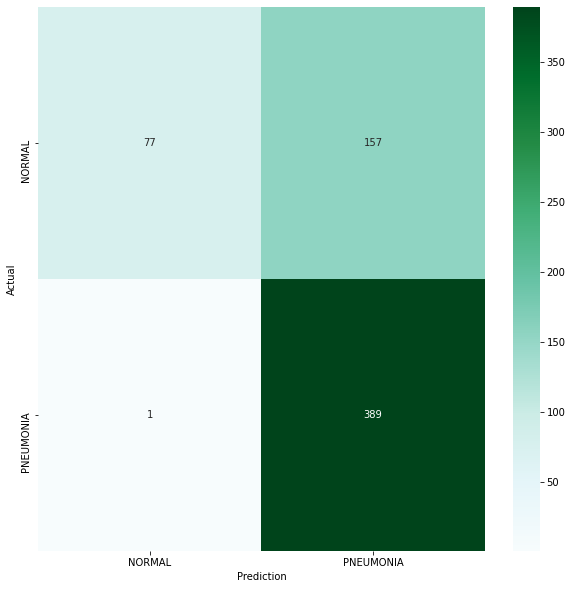

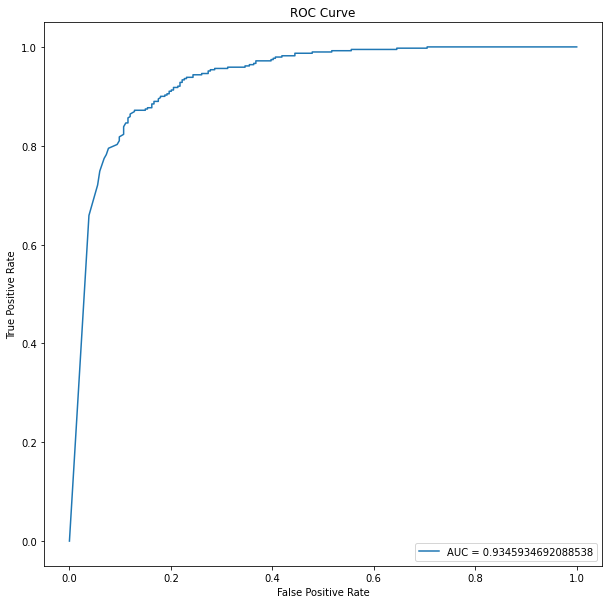

In [284]:
print_classification_report(y_test, pred)
plot_confusion(y_test, pred)
plot_roc_curve(y_test, pred_proba)

## Plots

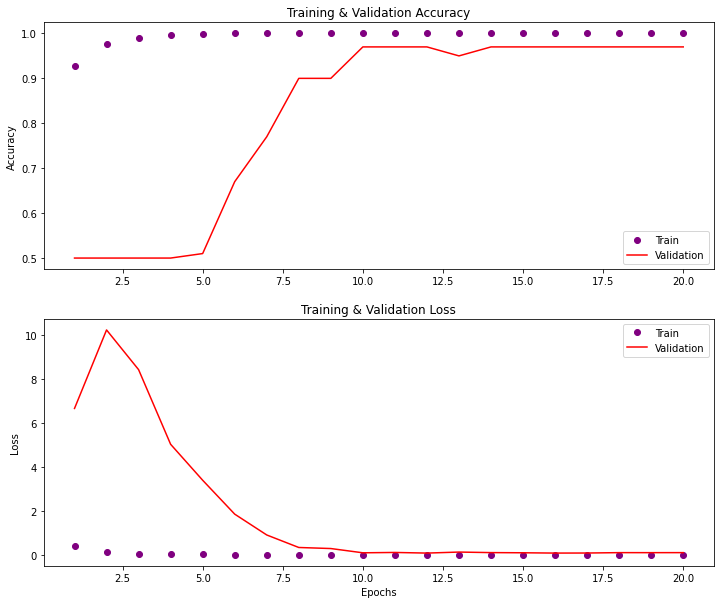

In [285]:
plot_performance(history_batchnorm, color_train='purple')

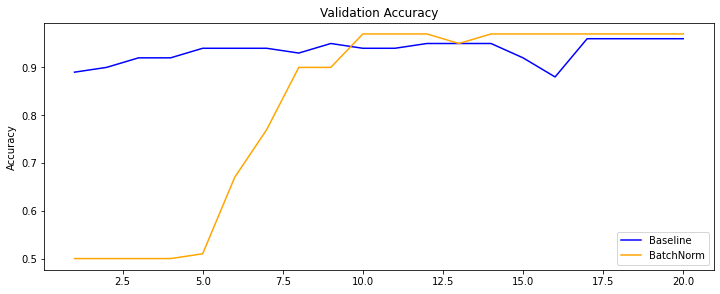

In [286]:
compare_history({'Baseline': history_baseline, 
                 'BatchNorm': history_batchnorm})

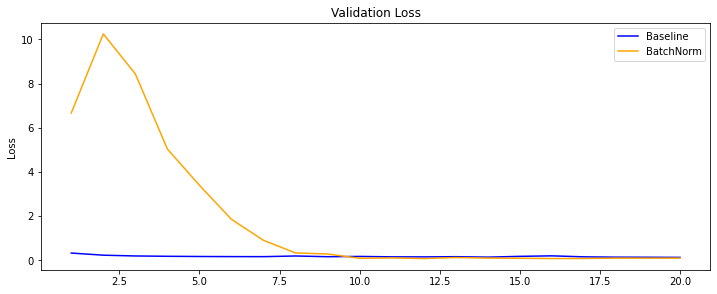

In [287]:
compare_history({'Baseline': history_baseline, 
                 'BatchNorm': history_batchnorm},
                metric='val_loss',
                title='Validation Loss',
                ylabel='Loss')

# Regularization
![alt text](https://miro.medium.com/max/1000/1*2BvEinjHM4SXt2ge0MOi4w.png)

* Add Augmentation
* Add Dropout

## Data Generators

In [0]:
train_datagen = ImageDataGenerator(
    rescale = 1. / 255,
    horizontal_flip=True,
    rotation_range=20, 
    width_shift_range=0.2, 
    height_shift_range=0.2,
    zoom_range=0.2
)

val_datagen = ImageDataGenerator(
    rescale = 1. / 255
)

test_datagen = ImageDataGenerator(
    rescale = 1. / 255
)

In [289]:
train_generator = train_datagen.flow_from_directory(train_dir, 
                                                    target_size=(image_x, image_y),
                                                    batch_size=batch_size,
                                                    class_mode='binary')

val_generator = val_datagen.flow_from_directory(val_dir, 
                                                    target_size=(image_x, image_y),
                                                    batch_size=batch_size,
                                                    class_mode='binary',
                                                    shuffle=False)

test_generator = test_datagen.flow_from_directory(test_dir, 
                                                    target_size=(image_x, image_y),
                                                    batch_size=batch_size,
                                                    class_mode='binary',
                                                    shuffle=False)

Found 5132 images belonging to 2 classes.
Found 100 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


## Model

In [0]:
model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=input_shape))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(32, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dropout(0.5))
model.add(Dense(64, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

In [291]:
model.summary()

Model: "sequential_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_33 (Conv2D)           (None, 198, 198, 32)      896       
_________________________________________________________________
max_pooling2d_33 (MaxPooling (None, 99, 99, 32)        0         
_________________________________________________________________
conv2d_34 (Conv2D)           (None, 97, 97, 32)        9248      
_________________________________________________________________
max_pooling2d_34 (MaxPooling (None, 48, 48, 32)        0         
_________________________________________________________________
conv2d_35 (Conv2D)           (None, 46, 46, 64)        18496     
_________________________________________________________________
max_pooling2d_35 (MaxPooling (None, 23, 23, 64)        0         
_________________________________________________________________
flatten_15 (Flatten)         (None, 33856)           

In [0]:
model.compile(loss='binary_crossentropy',
              optimizer=Adam(learning_rate=3e-4),
              metrics=['accuracy'])

## Train

In [293]:
history_regularize = model.fit(train_generator,
                               epochs=epochs,
                               validation_data=val_generator,
                               class_weight=class_weight)

Epoch 1/20
81/81 [==============================] - 88s 1s/step - loss: 0.8217 - accuracy: 0.6923 - val_loss: 0.4703 - val_accuracy: 0.8200
Epoch 2/20
81/81 [==============================] - 88s 1s/step - loss: 0.5268 - accuracy: 0.8424 - val_loss: 0.3816 - val_accuracy: 0.8200
Epoch 3/20
81/81 [==============================] - 88s 1s/step - loss: 0.4546 - accuracy: 0.8704 - val_loss: 0.3869 - val_accuracy: 0.8200
Epoch 4/20
81/81 [==============================] - 88s 1s/step - loss: 0.4844 - accuracy: 0.8521 - val_loss: 0.2335 - val_accuracy: 0.9100
Epoch 5/20
81/81 [==============================] - 88s 1s/step - loss: 0.4152 - accuracy: 0.8788 - val_loss: 0.2610 - val_accuracy: 0.8900
Epoch 6/20
81/81 [==============================] - 88s 1s/step - loss: 0.4098 - accuracy: 0.8784 - val_loss: 0.2188 - val_accuracy: 0.9300
Epoch 7/20
81/81 [==============================] - 88s 1s/step - loss: 0.3930 - accuracy: 0.8864 - val_loss: 0.2545 - val_accuracy: 0.9000
Epoch 8/20
81/81 [==

## Test

In [0]:
pred_proba = model.predict(test_generator)
pred = model.predict_classes(test_generator)
y_test = test_generator.classes

In [295]:
results = model.evaluate(test_generator)
print(f'Test Loss {results[0]:.2f} Accuracy {results[1]*100.0:.2f}%')
results_df.loc['Regularize'] = [results[0], results[1]]

10/10 [==============================] - 4s 435ms/step - loss: 0.2839 - accuracy: 0.8958
Test Loss 0.28 Accuracy 89.58%


              precision    recall  f1-score   support

      NORMAL       0.91      0.80      0.85       234
   PNEUMONIA       0.89      0.95      0.92       390

    accuracy                           0.90       624
   macro avg       0.90      0.88      0.89       624
weighted avg       0.90      0.90      0.89       624



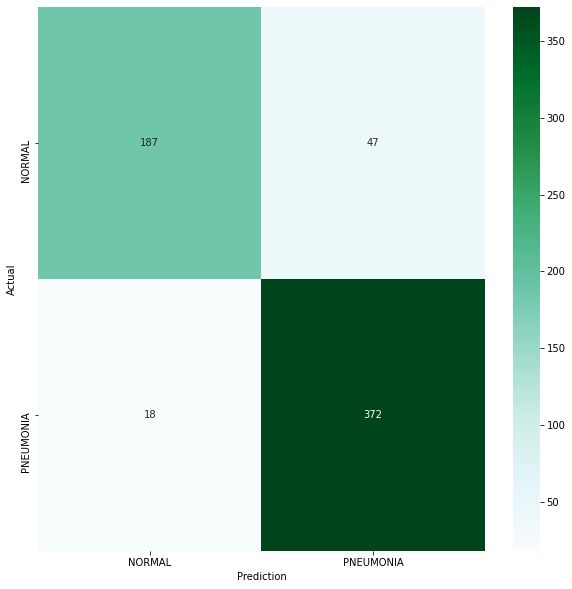

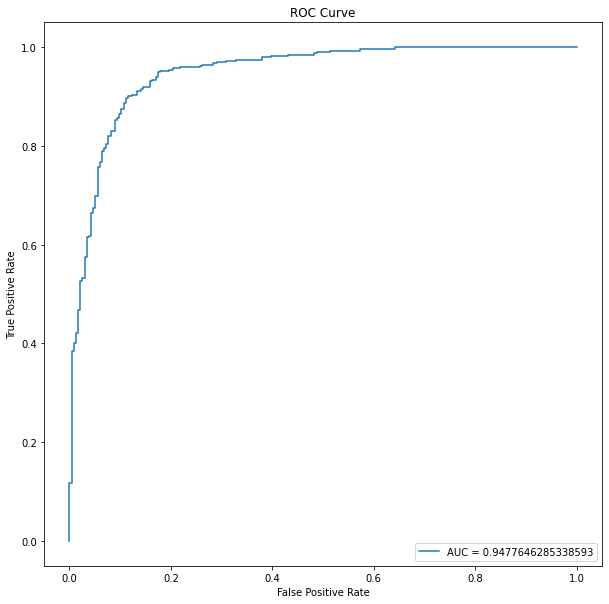

In [296]:
print_classification_report(y_test, pred)
plot_confusion(y_test, pred)
plot_roc_curve(y_test, pred_proba)

## Plots

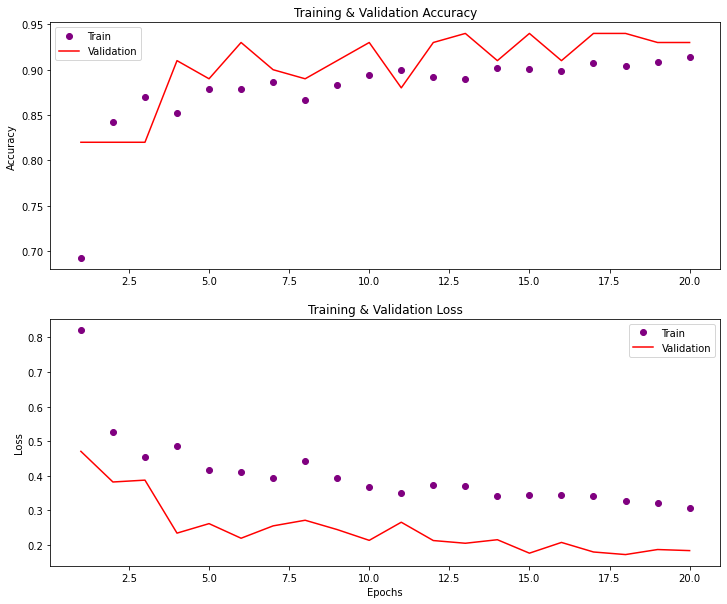

In [297]:
plot_performance(history_regularize, color_train='purple')

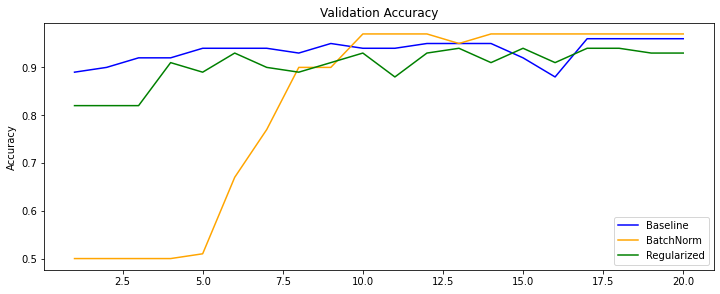

In [298]:
compare_history({'Baseline': history_baseline, 
                 'BatchNorm': history_batchnorm,
                 'Regularized': history_regularize})

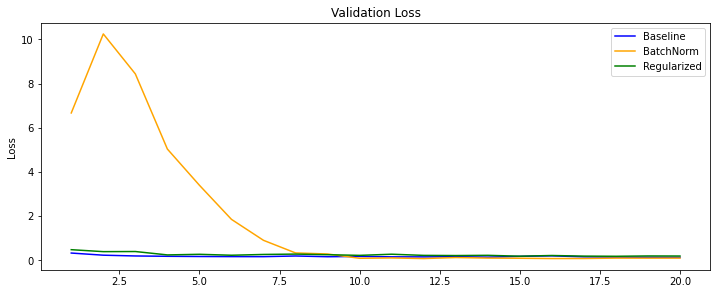

In [299]:
compare_history({'Baseline': history_baseline, 
                 'BatchNorm': history_batchnorm,
                 'Regularized': history_regularize},
                metric='val_loss',
                title='Validation Loss',
                ylabel='Loss')

# Transfer Learning
* Options
  * Feature extraction
  * Fine tuning
* Models
  * VGG
  * Resnet
  
![VGG16](https://miro.medium.com/max/470/1*3-TqqkRQ4rWLOMX-gvkYwA.png)



## Data Generators

In [0]:
train_datagen = ImageDataGenerator(
    rescale = 1. / 255,
    horizontal_flip=True,
    rotation_range=20, 
    width_shift_range=0.2, 
    height_shift_range=0.2,
    zoom_range=0.2
)

val_datagen = ImageDataGenerator(
    rescale = 1. / 255
)

test_datagen = ImageDataGenerator(
    rescale = 1. / 255
)

In [301]:
train_generator = train_datagen.flow_from_directory(train_dir, 
                                                    target_size=(image_x, image_y),
                                                    batch_size=batch_size,
                                                    class_mode='binary')

val_generator = val_datagen.flow_from_directory(val_dir, 
                                                    target_size=(image_x, image_y),
                                                    batch_size=batch_size,
                                                    class_mode='binary',
                                                    shuffle=False)

test_generator = test_datagen.flow_from_directory(test_dir, 
                                                    target_size=(image_x, image_y),
                                                    batch_size=batch_size,
                                                    class_mode='binary',
                                                    shuffle=False)

Found 5132 images belonging to 2 classes.
Found 100 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


## Model

In [0]:
base = VGG16(weights='imagenet',
             include_top=False,
             input_shape=input_shape)

In [303]:
base.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 200, 200, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 200, 200, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 200, 200, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 100, 100, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 100, 100, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 100, 100, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 50, 50, 128)       0     

In [0]:
base.trainable = False

In [0]:
model = Sequential()
model.add(base)
model.add(Flatten())
model.add(Dropout(0.5))
model.add(Dense(64, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

In [306]:
model.summary()

Model: "sequential_16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 6, 6, 512)         14714688  
_________________________________________________________________
flatten_16 (Flatten)         (None, 18432)             0         
_________________________________________________________________
dropout_6 (Dropout)          (None, 18432)             0         
_________________________________________________________________
dense_32 (Dense)             (None, 64)                1179712   
_________________________________________________________________
dense_33 (Dense)             (None, 1)                 65        
Total params: 15,894,465
Trainable params: 1,179,777
Non-trainable params: 14,714,688
_________________________________________________________________


In [0]:
model.compile(loss='binary_crossentropy',
              optimizer=Adam(learning_rate=3e-4),
              metrics=['accuracy'])

## Train

In [308]:
history_transfer = model.fit(train_generator,
                             epochs=epochs,
                             validation_data=val_generator,
                             class_weight=class_weight)

Epoch 1/20
81/81 [==============================] - 93s 1s/step - loss: 0.4809 - accuracy: 0.8560 - val_loss: 0.1615 - val_accuracy: 0.9300
Epoch 2/20
81/81 [==============================] - 93s 1s/step - loss: 0.3369 - accuracy: 0.9067 - val_loss: 0.1937 - val_accuracy: 0.9000
Epoch 3/20
81/81 [==============================] - 93s 1s/step - loss: 0.2948 - accuracy: 0.9178 - val_loss: 0.1435 - val_accuracy: 0.9400
Epoch 4/20
81/81 [==============================] - 93s 1s/step - loss: 0.2935 - accuracy: 0.9246 - val_loss: 0.1796 - val_accuracy: 0.9400
Epoch 5/20
81/81 [==============================] - 93s 1s/step - loss: 0.2659 - accuracy: 0.9271 - val_loss: 0.1595 - val_accuracy: 0.9200
Epoch 6/20
81/81 [==============================] - 93s 1s/step - loss: 0.2713 - accuracy: 0.9310 - val_loss: 0.1842 - val_accuracy: 0.9300
Epoch 7/20
81/81 [==============================] - 93s 1s/step - loss: 0.2568 - accuracy: 0.9312 - val_loss: 0.1450 - val_accuracy: 0.9300
Epoch 8/20
81/81 [==

## Test

In [0]:
pred_proba = model.predict(test_generator)
pred = model.predict_classes(test_generator)
y_test = test_generator.classes

In [310]:
results = model.evaluate(test_generator)
print(f'Test Loss {results[0]:.2f} Accuracy {results[1]*100.0:.2f}%')
results_df.loc['Transfer'] = [results[0], results[1]]

10/10 [==============================] - 5s 470ms/step - loss: 0.2615 - accuracy: 0.9071
Test Loss 0.26 Accuracy 90.71%


              precision    recall  f1-score   support

      NORMAL       0.94      0.81      0.87       234
   PNEUMONIA       0.89      0.97      0.93       390

    accuracy                           0.91       624
   macro avg       0.91      0.89      0.90       624
weighted avg       0.91      0.91      0.91       624



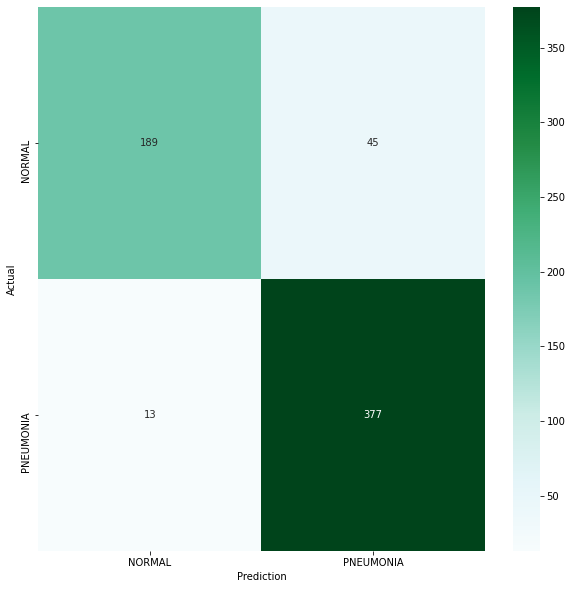

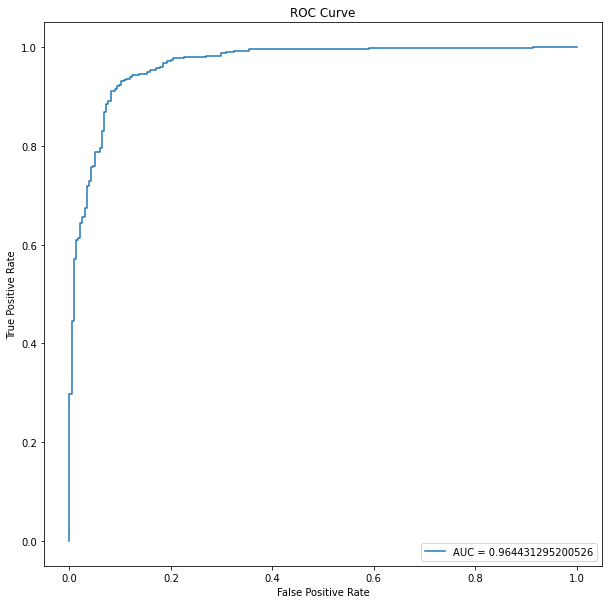

In [311]:
print_classification_report(y_test, pred)
plot_confusion(y_test, pred)
plot_roc_curve(y_test, pred_proba)

## Plots

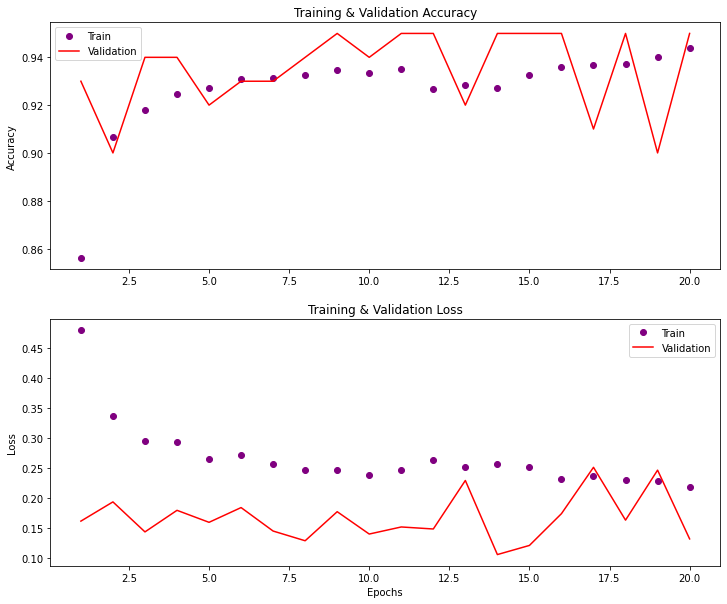

In [317]:
plot_performance(history_transfer, color_train='purple')

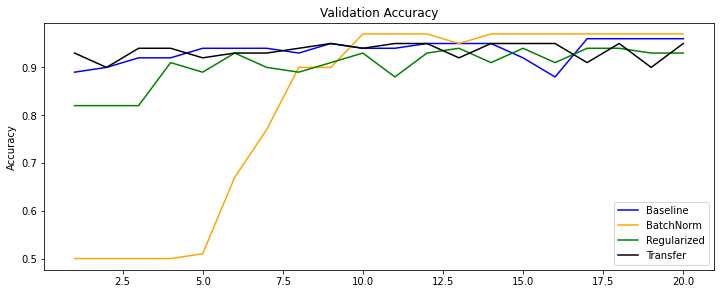

In [313]:
compare_history({'Baseline': history_baseline, 
                 'BatchNorm': history_batchnorm,
                 'Regularized': history_regularize,
                 'Transfer': history_transfer})

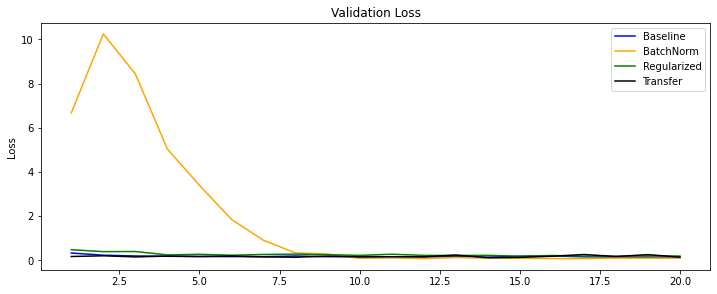

In [314]:
compare_history({'Baseline': history_baseline, 
                 'BatchNorm': history_batchnorm,
                 'Regularized': history_regularize,
                 'Transfer': history_transfer},
                metric='val_loss',
                title='Validation Loss',
                ylabel='Loss')

# Comparison

In [315]:
results_df

,Loss,Accuracy
Baseline,1.029989,0.785256
Batch Norm,2.032375,0.746795
Regularize,0.283900,0.895833
Transfer,0.261477,0.907051


# Recap
* Image augmentation & dropout are great improvements for image classification problems
* Transfer learning incorporates a way to use "feature engineering" from other projects (in the case of VGG16, ImageNet)
* BatchNorm didn't help the baseline in this case, but using it in conjunction with augmentation / dropout would prove useful